___
# Predictive Modelling - Time Series Analysis

Using the Tableau SuperStore dataset 

Data
The Super Store dataset contains data on order details of customers for orders of a superstore in the US. This includes the state, region, order date, shipping date, product ordered etc.


___
# Literature on Forecasting


### Forecasting Truisms

- **Forecasts are always wrong**
- **Aggregated forecasts - This could be aggregating by SKU (Common parts) / by time (month better than days) / By Location**
- **Shorter horizon forecasts are more accurate (postponement)**

### Methods of forecasting

- Judgmental , Experimental , Causal (regression) , Time Series 

### Metrics for measuring forecasts

- Accuracy - Closeness to actual observations (MAD, MSE, RMSE, MAPE)
- Bias - Persistent tendency to over or under predict (actual-forecast)/actual+forecast)

___
# Forecasting Procedure

The below is the set procedure on model evaluation and application in time series

* Split Data into train and test set
* Choose a Model
* Fit model in training set
* Evaluate model on test set
* Re-fit model on entire data set
* Forecast for future data

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

### The below are the algoritms used for demand planning in SAP's systems our notebook will be implementing as few of these algorithms (Time Series)

In [70]:
pd.read_csv('Data\Superstore\Models.csv')

,Statistical Algorithm,APO Demand Planning,IBP for Demand,This Notebook
0,Seasonal Linear Regression,Yes,No,No
1,Adaptive Response Rate Single Exponential Smoo...,No,Yes,No
2,Single Exponential Smoothing,Yes,Yes,Yes
3,Double Exponential Smoothing,Yes,Yes,Yes
4,Triple Exponential Smoothing,Yes,Yes,Yes
5,Automated Exponential Smoothing,Yes,Yes,Yes
6,Automated Exponential Smoothing [with paramete...,Yes,No,No
7,Croston Model,Yes,Yes,No
8,Simple Average,No,Yes,No
9,Simple Moving Average,Yes,Yes,Yes


### Read in data

In [71]:
data = pd.read_csv("Data\Walmart\Train.csv", encoding= 'unicode_escape')
data.rename({'Weekly_Sales':'Sales'}, axis=1,inplace=True)

## EDA & Cleaning: Cleaning the categorical features

### The below look into the data show us that this is a sales dataset with the most granular level information - [Order, Customer, Product] level

In [72]:
data.head()

,Store,Dept,Date,Sales,IsHoliday
0,1,1,2010-02-05,"24,924.50",False
1,1,1,2010-02-12,"46,039.49",True
2,1,1,2010-02-19,"41,595.55",False
3,1,1,2010-02-26,"19,403.54",False
4,1,1,2010-03-05,"21,827.90",False


In [73]:
### The summary statistics of the measure variables suggest that the range of the prducts the profitability and the volume normally bought by the customers

In [74]:
data.describe()

,Store,Dept,Sales
count,"421,570.00","421,570.00","421,570.00"
mean,22.20,44.26,"15,981.26"
std,12.79,30.49,"22,711.18"
min,1.00,1.00,"-4,988.94"
25%,11.00,18.00,"2,079.65"
50%,22.00,37.00,"7,612.03"
75%,33.00,74.00,"20,205.85"
max,45.00,99.00,"693,099.36"


In [75]:
data.isnull().sum()

Store        0
Dept         0
Date         0
Sales        0
IsHoliday    0
dtype: int64

In [76]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by=['Date'], inplace=True, ascending=True)
data.set_index(['Date'], drop=True, inplace=True)
data = pd.DataFrame(data[data['Store']==1].groupby(['Date'])['Sales'].sum())
data = data.resample(rule='W').sum()

In [77]:
data.head()

,Sales
Date,
2010-02-07,"1,643,690.90"
2010-02-14,"1,641,957.44"
2010-02-21,"1,611,968.17"
2010-02-28,"1,409,727.59"
2010-03-07,"1,554,806.68"


In [80]:
Technology = data

## Understanding Forecasting Levels

Forecasting can be done at different levels of aggregations (Time) or different levels of hierarchy (Company level / region level / city level)

- Strategic 

    Horizon : Years
    
    Purposes : Capacity Planning, Business Planning 
    
    Superstore : Aggregate forecasting by category at a company level
    
    
- Tactical

    Horizon : Quarter
    
    Purposes : Sales Planning, Budgeting
    
    Superstore : Aggregate forecasting by category at a region level at a company level
    
    
- Operational 

    Horizon : Days
    
    Purposes : Production Planning, Transportation Planning
    
    Superstore : Aggregate forecasting by product at a region level at a company level

### For this exercise forecasting at a category level at a monthly frequency will be explored

### Plotting the sales of Technology products 

> A first look at the sales data shows a highly seasonal data with level (i.e a minimum sales) with no or very low trend.

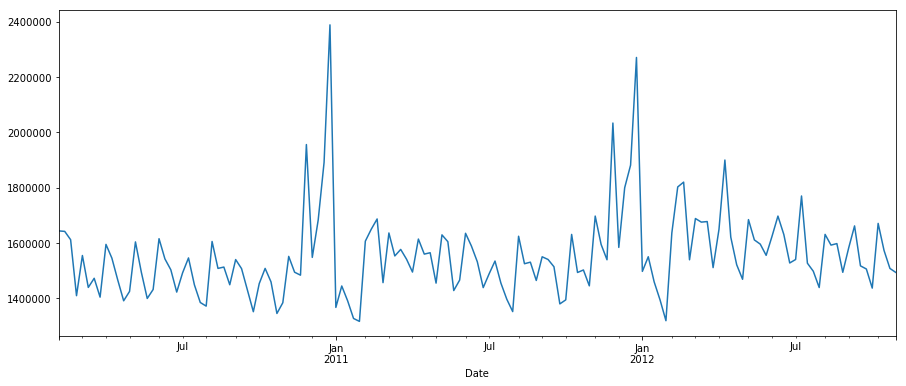

In [82]:
Technology['Sales'].plot(figsize=(15,6)).autoscale(axis='x', tight=True)

### In the next step we will decompose this dataset to find the various components of the sales data.

> The decomposition is used to split the sales data in to tend, seasonal and error components

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

> Based on this chart, it looks like the trend in the later days (after Jul, 2012) is picking up at a linear rate especially hence the data in the later part is more important than the earlier

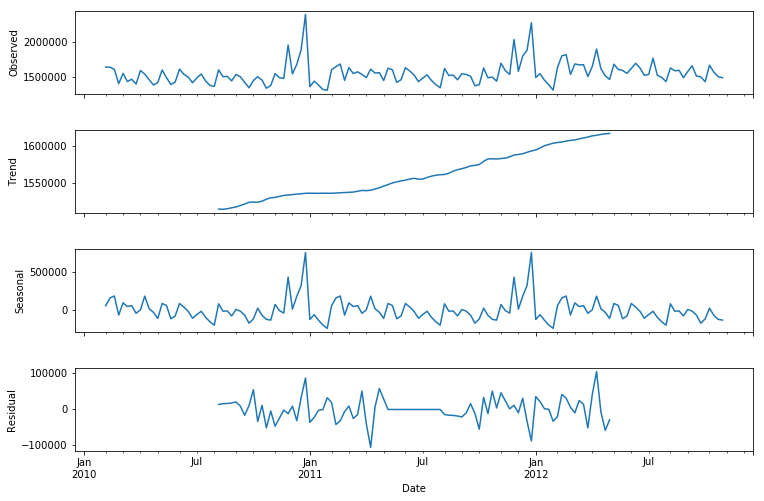

In [84]:
result = seasonal_decompose(Technology['Sales'], model='add')
fig = result.plot()   
fig.set_size_inches(12, 8)

## Step 1 : Split Data into train and test set

> 1. As we described earlier we will first split the data into Training and test set.
> 2. Training set is to build the model
> 3. Testing set is to check how effective the model is on unknow data

In [85]:
# We have 31 months of sales with us here we will split the data in 24 month for Training and 7 months for testing
Technology.shape

(143, 1)

In [86]:
Technology.index.max()

Timestamp('2012-10-28 00:00:00', freq='W-SUN')

In [87]:
Technology.index.min()

Timestamp('2010-02-07 00:00:00', freq='W-SUN')

In [21]:
Technology_Train = Technology[:'2013-12-01'].copy()
Technology_Test = Technology['2014-01-01':].copy()

In [22]:
print("Train Shape : {} | Test Shape : {}".format(Technology_Train.shape, Technology_Test.shape))

Train Shape : (36, 1) | Test Shape : (12, 1)


In [23]:
Technology_Test.head()

,Sales
Order Date,
2014-01-01,22858.943
2014-02-01,15121.738
2014-03-01,38463.480
2014-04-01,16162.071
2014-05-01,19964.464


In [24]:
Technology_Train.tail()

,Sales
Order Date,
2013-08-01,19152.620
2013-09-01,12449.212
2013-10-01,9235.440
2013-11-01,33057.445
2013-12-01,20794.926


___
# SMA
## Simple Moving Average : Plotting the Model

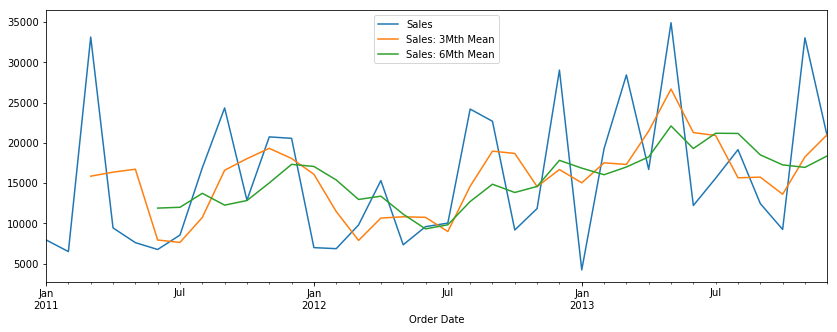

In [25]:
Technology_Train['Sales: 3Mth Mean'] = Technology_Train['Sales'].rolling(window=3).mean()
Technology_Train['Sales: 6Mth Mean'] = Technology_Train['Sales'].rolling(window=6).mean()
Technology_Train[['Sales','Sales: 3Mth Mean','Sales: 6Mth Mean']].plot(figsize=(14,5)).autoscale(axis='x',tight=True)

### Fitting and plotting the Simple moving average on test data.

In [26]:
Technology_Test['Sales: 3Mth Mean'] = Technology_Train['Sales'].rolling(3).mean().iloc[-1]
Technology_Test['Sales: 6Mth Mean'] = Technology_Train['Sales'].rolling(6).mean().iloc[-1]

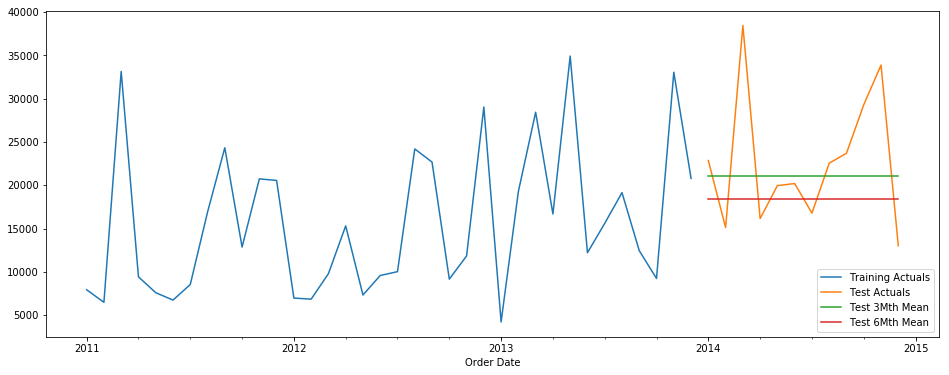

In [27]:
Technology_Train['Sales'].plot(legend=True,label='Training Actuals',figsize=(16,6))
Technology_Test['Sales'].plot(legend=True,label='Test Actuals')
Technology_Test['Sales: 3Mth Mean'].plot(legend=True,label='Test 3Mth Mean');
Technology_Test['Sales: 6Mth Mean'].plot(legend=True,label='Test 6Mth Mean');

### Evaluation Metrics

In [28]:
from sklearn import metrics

print('Mean Absolute Error : ', metrics.mean_absolute_error(Technology_Test['Sales'], Technology_Test['Sales: 3Mth Mean']))
print('Mean Squared Error : ', metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['Sales: 3Mth Mean']))
print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['Sales: 3Mth Mean'])))
print('Mean Absolute Percentage Error:', np.mean(np.abs((Technology_Test['Sales'] - Technology_Test['Sales: 3Mth Mean']) / Technology_Test['Sales'])) * 100, "%")

Mean Absolute Error :  5792.852416666666
Mean Squared Error :  57766036.12758238
Root Mean Squared Error :  7600.3971032823265
Mean Absolute Percentage Error: 25.245766965375786 %


In [29]:
print('Mean Absolute Error : ', metrics.mean_absolute_error(Technology_Test['Sales'], Technology_Test['Sales: 6Mth Mean']))
print('Mean Squared Error : ', metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['Sales: 6Mth Mean']))
print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['Sales: 6Mth Mean'])))
print('Mean Absolute Percentage Error:', np.mean(np.abs((Technology_Test['Sales'] - Technology_Test['Sales: 6Mth Mean']) / Technology_Test['Sales'])) * 100, "%")

Mean Absolute Error :  6360.145083333336
Mean Squared Error :  73457362.92797877
Root Mean Squared Error :  8570.727094475635
Mean Absolute Percentage Error: 24.89131642807394 %


___
# EWMA
## Exponentially Weighted Moving Average 

In [30]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [31]:
span = 3
alpha = 2/(span+1)
print('Span : {} | Alpha : {}'.format(span, alpha))

Span : 3 | Alpha : 0.5


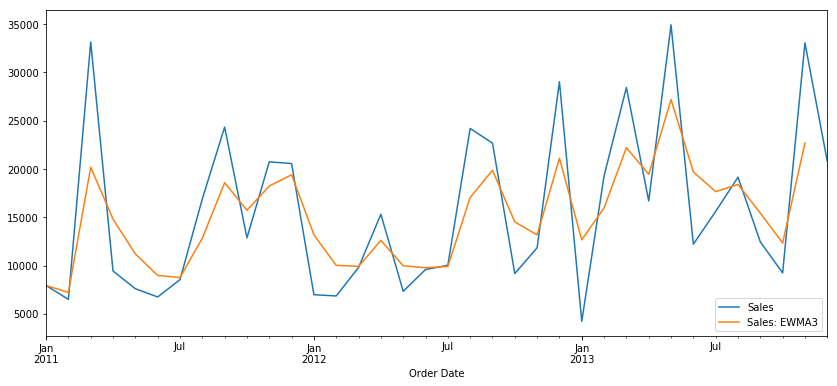

In [32]:
Technology_Train['Sales: EWMA3']=SimpleExpSmoothing(Technology_Train['Sales']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
Technology_Train[['Sales','Sales: EWMA3']].plot(figsize=(14,6)).autoscale(axis='x',tight=True);

In [33]:
ModelEWMA = SimpleExpSmoothing(Technology_Train['Sales']).fit(smoothing_level=alpha,optimized=False)
test_predictions = ModelEWMA.forecast(12).rename('HW Forecast')
Technology_Test['Sales: EWMA'] = pd.Series(test_predictions, index=Technology_Test.index)

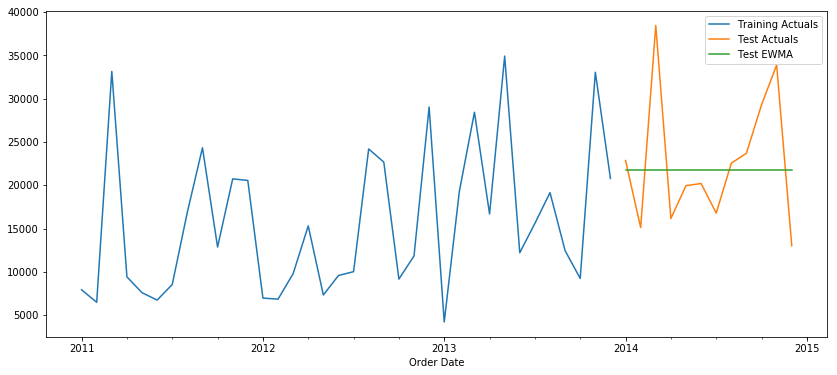

In [34]:
Technology_Train['Sales'].plot(legend=True,label='Training Actuals',figsize=(14,6))
Technology_Test['Sales'].plot(legend=True,label='Test Actuals')
Technology_Test['Sales: EWMA'].plot(legend=True,label='Test EWMA');

In [35]:
print('Mean Absolute Error : ', metrics.mean_absolute_error(Technology_Test['Sales'], Technology_Test['Sales: EWMA']))
print('Mean Squared Error : ', metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['Sales: EWMA']))
print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['Sales: EWMA'])))
print('Mean Absolute Percentage Error:', np.mean(np.abs((Technology_Test['Sales'] - Technology_Test['Sales: EWMA']) / Technology_Test['Sales'])) * 100, "%")

Mean Absolute Error :  5792.8524166666675
Mean Squared Error :  55931485.748555064
Root Mean Squared Error :  7478.735571509068
Mean Absolute Percentage Error: 26.104351922630652 %


___
## Double Exponential Smoothing (Holt’s Linear Trend method)

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

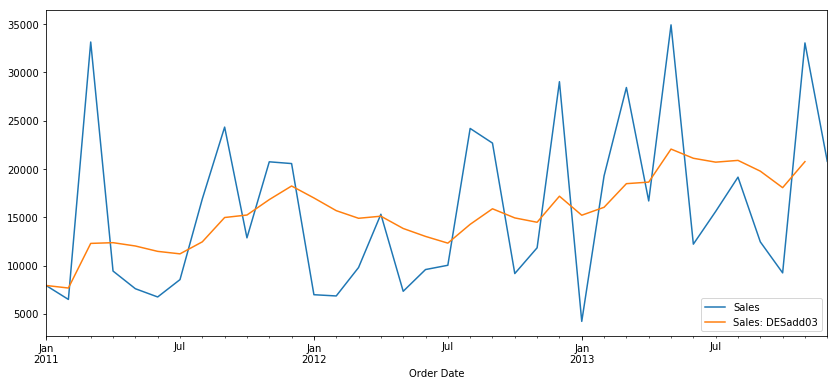

In [37]:
Technology_Train['Sales: DESadd03'] = ExponentialSmoothing(Technology_Train['Sales'], trend='add').fit().fittedvalues.shift(-1)
Technology_Train[['Sales','Sales: DESadd03']].plot(figsize=(14,6)).autoscale(axis='x',tight=True)

In [38]:
fitted_model = ExponentialSmoothing(Technology_Train['Sales'], trend='add').fit()
test_predictions = fitted_model.forecast(12).rename('H Forecast')
Technology_Test['DESadd03'] = test_predictions

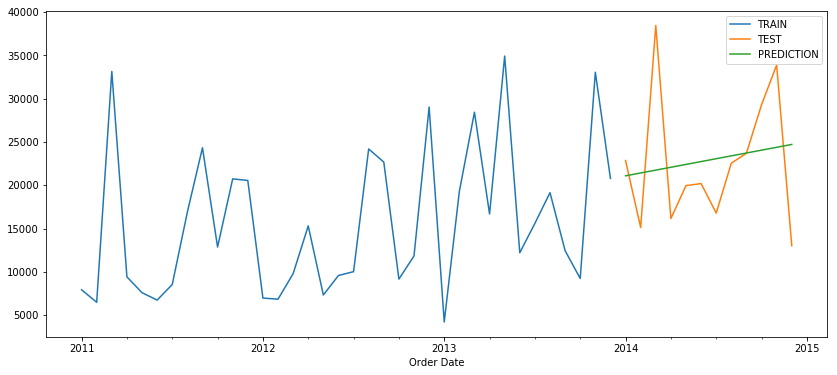

In [39]:
Technology_Train['Sales'].plot(legend=True,label='TRAIN')
Technology_Test['Sales'].plot(legend=True,label='TEST',figsize=(14,6));
Technology_Test['DESadd03'].plot(legend=True,label='PREDICTION');

In [40]:
print('Mean Absolute Error : ', metrics.mean_absolute_error(Technology_Test['Sales'], Technology_Test['DESadd03']))
print('Mean Squared Error : ', metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['DESadd03']))
print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['DESadd03'])))
print('Mean Absolute Percentage Error:', np.mean(np.abs((Technology_Test['Sales'] - Technology_Test['DESadd03']) / Technology_Test['Sales'])) * 100, "%")

Mean Absolute Error :  5773.928423805835
Mean Squared Error :  55365360.053464316
Root Mean Squared Error :  7440.79028420129
Mean Absolute Percentage Error: 27.61680876077126 %


___
## Triple Exponential Smoothing (Holt-Winters Method)
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 


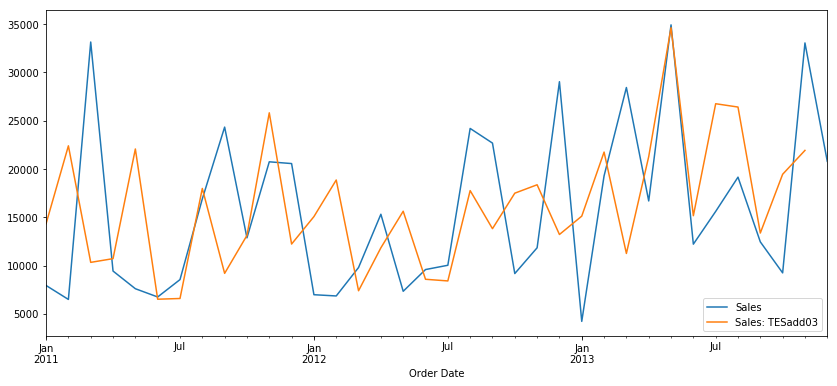

In [41]:
Technology_Train['Sales: TESadd03'] = ExponentialSmoothing(Technology_Train['Sales'], trend='add',seasonal='mul',seasonal_periods=3).fit().fittedvalues.shift(-1)
Technology_Train[['Sales','Sales: TESadd03']].plot(figsize=(14,6)).autoscale(axis='x',tight=True)

In [42]:
fitted_model = ExponentialSmoothing(Technology_Train['Sales'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(12).rename('HW Forecast')
Technology_Test['TESadd03'] = test_predictions

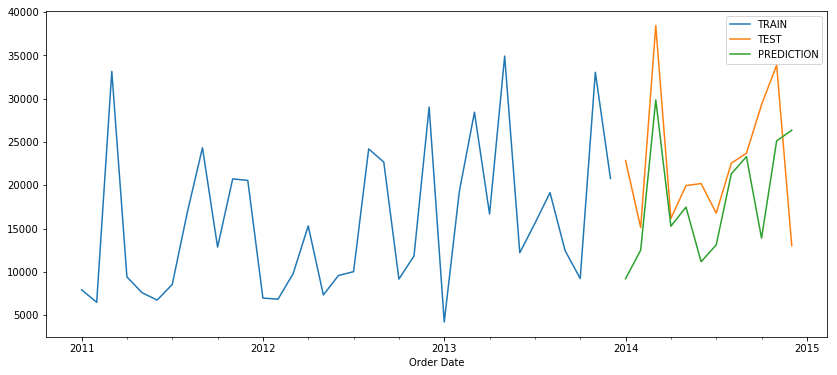

In [43]:
Technology_Train['Sales'].plot(legend=True,label='TRAIN')
Technology_Test['Sales'].plot(legend=True,label='TEST',figsize=(14,6));
Technology_Test['TESadd03'].plot(legend=True,label='PREDICTION');

In [44]:
print('Mean Absolute Error : ', metrics.mean_absolute_error(Technology_Test['Sales'], Technology_Test['TESadd03']))
print('Mean Squared Error : ', metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['TESadd03']))
print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(Technology_Test['Sales'], Technology_Test['TESadd03'])))
print('Mean Absolute Percentage Error:', np.mean(np.abs((Technology_Test['Sales'] - Technology_Test['TESadd03']) / Technology_Test['Sales'])) * 100, "%")

Mean Absolute Error :  6673.041895007646
Mean Squared Error :  71928411.73085171
Root Mean Squared Error :  8481.061945938829
Mean Absolute Percentage Error: 30.992646898944926 %


___
## Autoregressive Integrated Moving average (Box–Jenkins method)


In [56]:
setpwise_fit = auto_arima(Technology_Train['Sales'], start_p=1, start_q=1, max_p = 4, max_q=4, seasonal=True, trace=True, m=12)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=757.414, BIC=760.581, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=761.168, BIC=767.502, Fit time=0.038 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=759.325, BIC=764.076, Fit time=0.016 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=759.360, BIC=764.111, Fit time=0.023 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=759.482, BIC=764.232, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=761.455, BIC=767.789, Fit

In [57]:
setpwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:                        SARIMAX   Log Likelihood                -376.707
Date:                Sun, 18 Jul 2021   AIC                            757.414
Time:                        14:01:20   BIC                            760.581
Sample:                             0   HQIC                           758.519
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.567e+04   1792.667      8.741      0.000    1.22e+04    1.92e+04
sigma2      7.186e+07   2.49e+07      2.889      0.004    2.31e+07    1.21e+08
===================================================================================
Ljung-Box (Q):                       49.09   Jarque-Bera (JB):                 3.78
Prob(Q):                              0.06   Prob(JB):                         0.15
Heteroskedasticity (H):               1.32   Skew:                             0.75
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
setpwise_fit

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)